In [124]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from proj1_helpers import *
from implementations import *
from plots import *
from utils import *
from validation import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [3]:
import datetime
DATA_TRAIN_PATH = 'data/train.csv' # TODO: download train data and supply path here

labels, input_data, ids = load_csv_data(DATA_TRAIN_PATH)

In [4]:
# standardize the data : 
x, mean_x, std_x = standardize(input_data)
y, tx = build_model_data(x, labels)

In [5]:
print(f'shape y : {y.shape}, shape x : {tx.shape}')

shape y : (250000,), shape x : (250000, 31)


## Do your thing crazy machine learning thing here :) ...

In [37]:
# splitting data in train and test splits
seed = 46
ratio = 0.8
x_train, y_train, x_test, y_test = split_data(tx, y, ratio=ratio, seed=seed)

## Least Squares GD

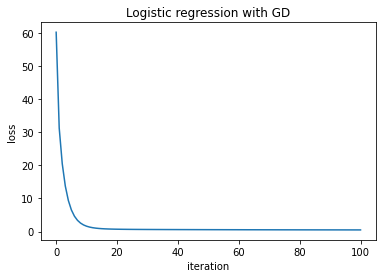

Train loss is 0.4836
Test loss is 0.4802


In [67]:
max_iters = 100
gamma = 0.05
initial_w = np.ones((x_train.shape[1]))

plt.title('Logistic regression with GD')
w, loss = least_squares_GD(y_train, x_train, initial_w, max_iters, gamma, plot_loss = True)
test_loss = compute_mse(y_test, x_test, w)
print("Train loss is {:.4f}".format(loss))
print("Test loss is {:.4f}".format(test_loss))

### Cross validation for least squares GD

100%|██████████| 6/6 [01:45<00:00, 17.66s/it]


Train loss is 0.4089
Test loss is 0.4089


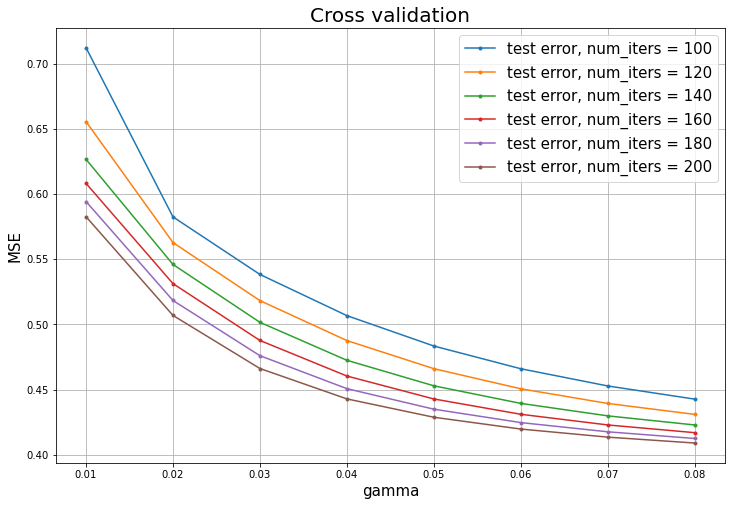

In [107]:
# parameters setting
type_ = 'GD'
bd_left = -2
bd_right = -2
# grid for hyperparameters
gammas = np.linspace(10**bd_left, 8*10**bd_right, 8)
max_iters = np.arange(100, 220, 20)
cross_validation_demo(type_=type_, y=y, tx=tx, bd_left=bd_left, bd_right=bd_right, gammas=gammas, max_iters=max_iters, seed=seed)

**Gradient decent converges if gamma < 0.09. Also we decided not to increase max_iter parameter up to 2000 due to the duration of the computations.  
In this setting the best gamma = 0.08 and the best max_iter = 2000.  
Best test loss = 0.3708**

## Least Squares SGD

In [ ]:
max_iters = 100
gamma = 0.01
initial_w = np.ones((x_train.shape[1]))

plt.title('Logistic regression with GD')
w, loss = least_squares_SGD(y_train, x_train, initial_w, max_iters, gamma, plot_loss = True)
test_loss = compute_mse(y_test, x_test, w)
print("Train loss is {:.2f}".format(loss))
print("Test loss is {:.2f}".format(test_loss))

### Cross validation for least squares SGD

In [89]:
# parameters setting
type_ = 'SGD'
bd_left = -2
bd_right = -2
# grid for hyperparameters
gammas = np.linspace(10**bd_left, 5*10**bd_right, 5)
max_iters = np.arange(100, 220, 20)
cross_validation_demo(type_=type_, y=y, tx=tx, bd_left=bd_left, bd_right=bd_right, gammas=gammas, max_iters=max_iters, seed=seed)

## Least Squares

In [97]:
w, loss = least_squares(y, tx)
test_loss = compute_mse(y_test, x_test, w)
print("Train loss is {:.4f}".format(loss))
print("Test loss is {:.4f}".format(test_loss))

Train loss is 0.3394
Test loss is 0.3373


## Ridge regression

In [98]:
w, loss = ridge_regression(y, tx, lambda_=1e-5)
test_loss = compute_mse(y_test, x_test, w)
print("Train loss is {:.4f}".format(loss))
print("Test loss is {:.4f}".format(test_loss))

Train loss is 0.3394
Test loss is 0.3373


100%|██████████| 3/3 [03:37<00:00, 72.57s/it]


Train loss is 0.3245
Test loss is 0.3395


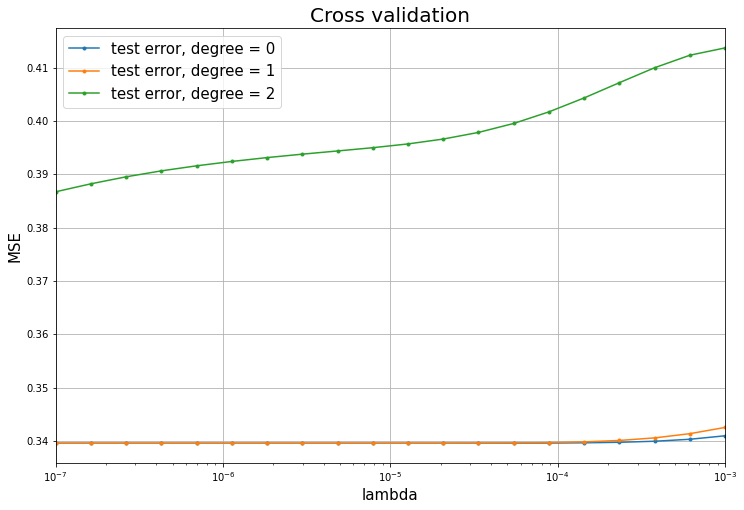

In [96]:
# parameters setting
type_ = 'RR'
bd_left = -5
bd_right = -2
# grid for hyperparameters
lambdas = np.logspace(bd_left, bd_right, 20)
degrees = np.arange(3)
cross_validation_demo(type_=type_, y=y, tx=tx, bd_left=bd_left, bd_right=bd_right, lambdas=lambdas, degrees=degrees, seed=seed)

**The oplimal degree is 0, which means that it's better not to apply polynomical transformation to the basis, let's find best lambda for degree = 0**

100%|██████████| 1/1 [00:06<00:00,  6.05s/it]


Train loss is 0.3394
Test loss is 0.3395


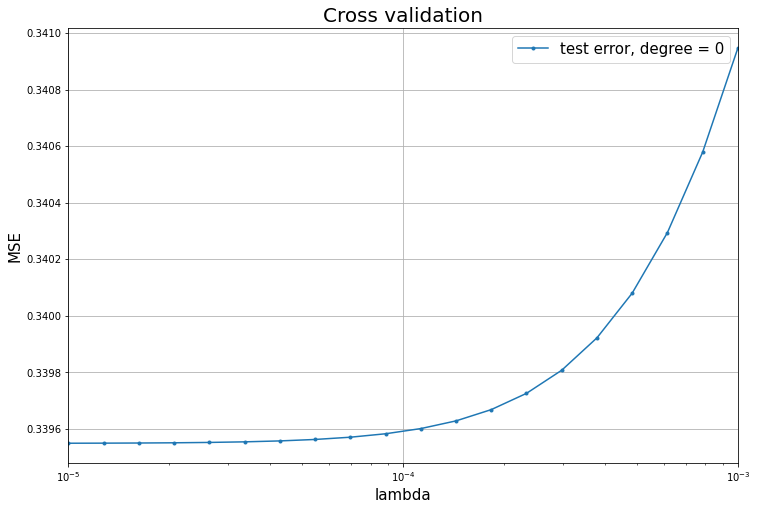

In [99]:
# parameters setting
type_ = 'RR'
bd_left = -5
bd_right = -3
# grid for hyperparameters
lambdas = np.logspace(bd_left, bd_right, 20)
degrees = np.arange(1)
cross_validation_demo(type_=type_, y=y, tx=tx, bd_left=bd_left, bd_right=bd_right, lambdas=lambdas, degrees=degrees, seed=seed)

**Optimal lambda is equal 10^{-5}  
Test error: 0.3395**

10it [00:08,  1.13it/s]


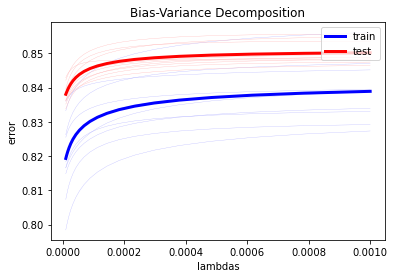

In [103]:
#bias/variance decomposition : 
def bias_variance_demo():
    """The entry."""
    # define parameters
    seeds = range(100)
    num_data = 10000
    ratio_train = 0.005
    lambdas = np.logspace(-5, -3, 20)
    degree=0
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(lambdas)))
    rmse_te = np.empty((len(seeds), len(lambdas)))
    for index_seed, seed in tqdm(enumerate(seeds)):
        np.random.seed(seed)
        # split data with a specific seed
        x_train,y_train,x_test,y_test = split_data(tx, y, ratio_train, seed)
        if degree == 0:
            x_train_phi =  x_train
            x_test_phi  =  x_test
        else:
            x_train_phi =  build_poly(x_train,degree)
            x_test_phi  =  build_poly(x_test,degree)
        for index_degree,lambda_ in enumerate(lambdas) :
            w_tr,_ = ridge_regression(y_train,x_train_phi,lambda_)
            rmse_te[index_seed,index_degree] = np.sqrt(2*compute_mse(y_test,x_test_phi,w_tr))
            rmse_tr[index_seed,index_degree] = np.sqrt(2*compute_mse(y_train,x_train_phi,w_tr))
        # bias_variance_decomposition
    bias_variance_decomposition_visualization(lambdas, rmse_tr, rmse_te)

bias_variance_demo()

## Logistic Regression

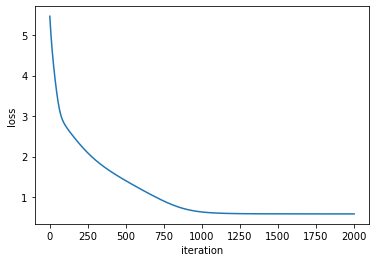

Train loss is 0.59
Test loss is 1.79


In [23]:
max_iters = 2000
gamma = 0.01
initial_w = np.ones((x_train.shape[1]))

w_log, loss = logistic_regression(y_train, x_train, initial_w, max_iters, gamma, plot_loss = True)
test_loss = compute_mse(y_test, x_test, w)
print("Train loss is {:.2f}".format(loss))
print("Test loss is {:.2f}".format(test_loss))

### Cross validation for logistic regression

In [111]:
bd_left = -4
bd_right = -1
np.linspace(10**bd_left, 10**bd_right, 10)

array([0.0001, 0.0112, 0.0223, 0.0334, 0.0445, 0.0556, 0.0667, 0.0778,
       0.0889, 0.1   ])

100%|██████████| 6/6 [29:34<00:00, 295.79s/it]


Train loss is 0.5669
Test loss is 0.5669


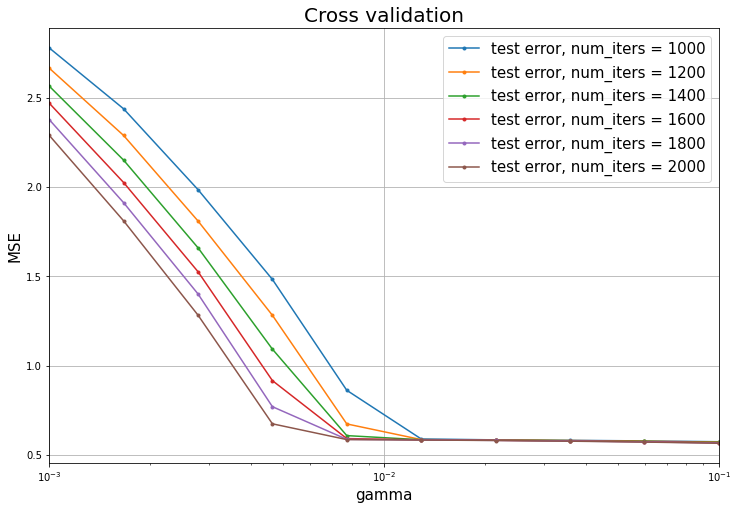

In [113]:
# parameters setting
type_ = 'LR'
bd_left = -3
bd_right = -1
# grid for hyperparameters
# gammas = np.linspace(10**bd_left, 10**bd_right, 10)
gammas = np.logspace(bd_left, bd_right, 10)
max_iters = np.arange(1000, 2200, 200)
cross_validation_demo(type_=type_, y=y, tx=tx, bd_left=bd_left, bd_right=bd_right, gammas=gammas, max_iters=max_iters, seed=seed)

## Logistic Regression with Regularization

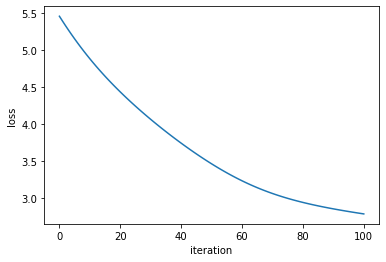

Train loss is 2.78
Test loss is 0.34


In [114]:
max_iters = 100
gamma = 0.01
initial_w = np.ones((x_train.shape[1]))
lambda_ = 1e-4

w, loss = reg_logistic_regression(y_train, x_train, lambda_, initial_w, max_iters, gamma, plot_loss = True)
print("Train loss is {:.2f}".format(loss))
print("Test loss is {:.2f}".format(test_loss))

### Cross calidation for logistic regression with regularizarion

100%|██████████| 1/1 [00:45<00:00, 45.42s/it]


Train loss is 0.5899
Test loss is 0.5899


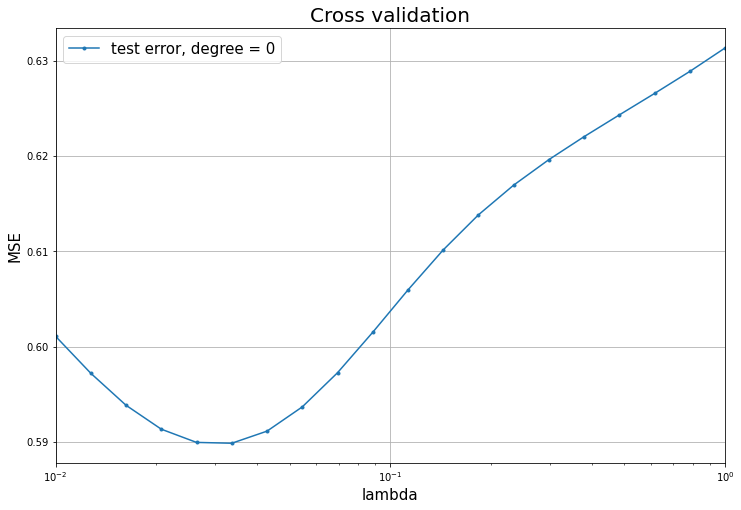

In [126]:
# parameters setting
type_ = 'RLR'
bd_left = -2
bd_right = 0
max_iters = 100
gammas = 0.1
# grid for hyperparameters
lambdas = np.logspace(bd_left, bd_right, 20)
degrees = np.arange(1)
cross_validation_demo(type_=type_, y=y, tx=tx, bd_left=bd_left, bd_right=bd_right, lambdas=lambdas, degrees=degrees, max_iters=max_iters, gammas=gammas, seed=seed)

# Look at the results : 


# 1. Split the data

In [ ]:
ratio = 0.7
tx_tr, tx_te, y_tr, y_te = split_data(tx, y, ratio)

# 2. Handle outliers 

# 3 Accuracy of the models

In [ ]:
#weights, loss = least_squares(y_tr, tx_tr)
y_pred = predict_labels(w_log, tx_te)
accu  = accuracy(y_pred,y_te)
print("accuracy:",accu)

# 4. Confusion matrix 

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
#confusion matrix
plt.figure(1)
cm=confusion_matrix(y_pred,y_te)
sn.heatmap(cm,annot=True)
plt.title("confusion matrix")
plt.xlabel("predicted")
plt.ylabel("expected")


## Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = 'C:/Users/saadc/Desktop/EPFL/ML/ML_course/projects/project1/scripts/data/test.csv'  # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
weights = w_log
weights = weights[1:31]
y_prediction = predict_labels(weights, tX_test)
y_prediction.shape

In [ ]:
OUTPUT_PATH = 'C:/Users/saadc/Desktop/EPFL/ML/ML_course/projects/project1/scripts/data/pred.csv' # TODO: fill in desired name of output file for submission
create_csv_submission(ids_test, y_prediction, OUTPUT_PATH)